In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from sklearn import tree

In [37]:
def get_testing_results(df):    
    X = df.drop('heart_attack', axis=1)
    y = df['heart_attack']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models
    models = [
        GaussianNB(),
        LogisticRegression(),
        DecisionTreeClassifier()
    ]

    # Create lists to store results
    train_results = []
    test_results = []
    feature_importances = []

    # Loop through models and calculate metrics
    for model in models:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        cm_train = confusion_matrix(y_train, y_pred_train)
        cm_test = confusion_matrix(y_test, y_pred_test)
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        fnr_train = cm_train[1, 0] / (cm_train[1, 0] + cm_train[1, 1])
        fnr_test = cm_test[1, 0] / (cm_test[1, 0] + cm_test[1, 1])
        train_results.append({'model': type(model).__name__, 'f1_score': f1_train, 'false_negative_rate': fnr_train})
        test_results.append({'model': type(model).__name__, 'f1_score': f1_test, 'false_negative_rate': fnr_test})

        # Get feature importances
        if isinstance(model, DecisionTreeClassifier):
            importances = model.feature_importances_
        elif isinstance(model, LogisticRegression):
            importances = np.abs(model.coef_[0])
        elif isinstance(model, GaussianNB):
            results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            importances = results.importances_mean
        feature_importances.append({
            'model': type(model).__name__,
            'feature_importances': importances
        })

    # Create DataFrames from the results
    train_results_df = pd.DataFrame(train_results)
    test_results_df = pd.DataFrame(test_results)

    print("Training Results:")
    print(train_results_df)
    print("\nTesting Results:")
    print(test_results_df)

    # Plot top 10 feature importances for each model
    for feature_importance in feature_importances:
        model_name = feature_importance['model']
        importances = feature_importance['feature_importances']
        top_10_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)[:10]
        plt.figure(figsize=(12, 8))  # Make the graph bigger
        plt.bar([x[0] for x in top_10_importances], [x[1] for x in top_10_importances])
        plt.title(f"Top 10 Feature Importances for {model_name}")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()

In [38]:
df = pd.read_csv('HA_cleaned.csv')

c:\Users\user\anaconda3\envs\CUHK\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Results:
                    model  f1_score  false_negative_rate
0              GaussianNB  0.608979             0.420412
1      LogisticRegression  0.539422             0.514413
2  DecisionTreeClassifier  1.000000             0.000000

Testing Results:
                    model  f1_score  false_negative_rate
0              GaussianNB  0.610648             0.420332
1      LogisticRegression  0.527279             0.532356
2  DecisionTreeClassifier  0.527794             0.470968


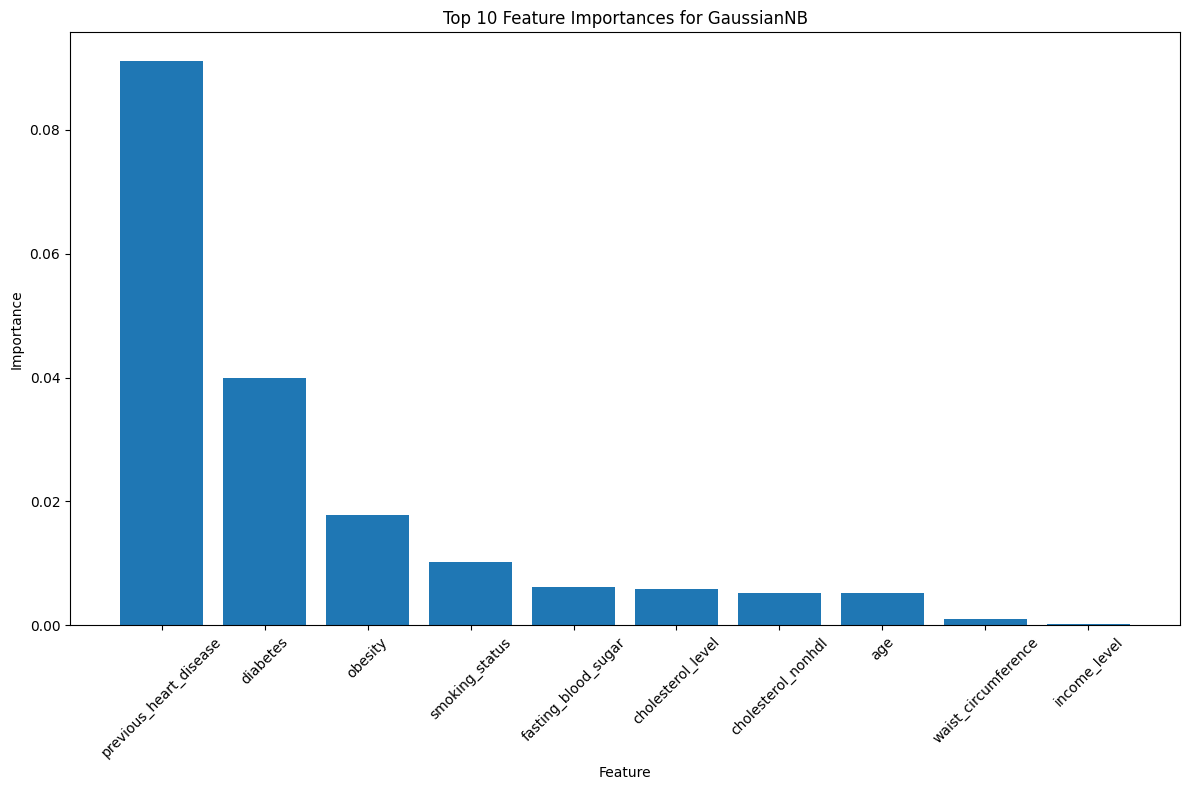

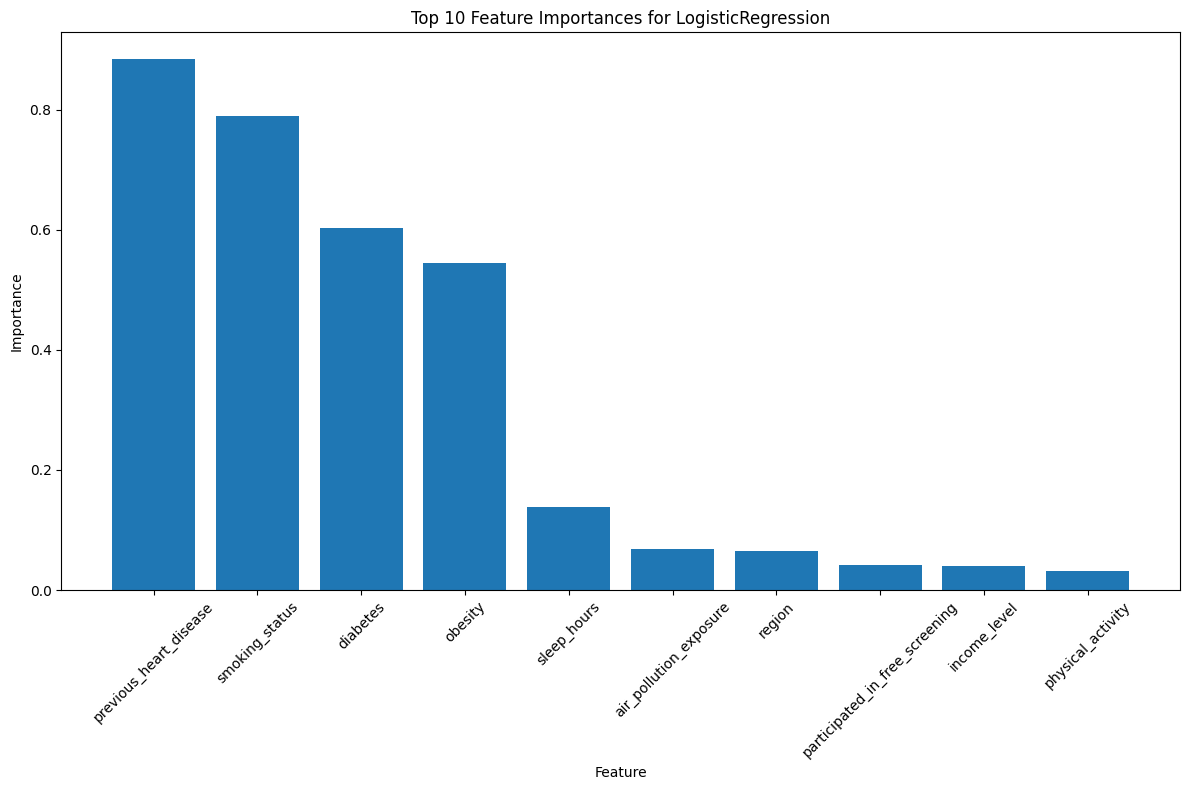

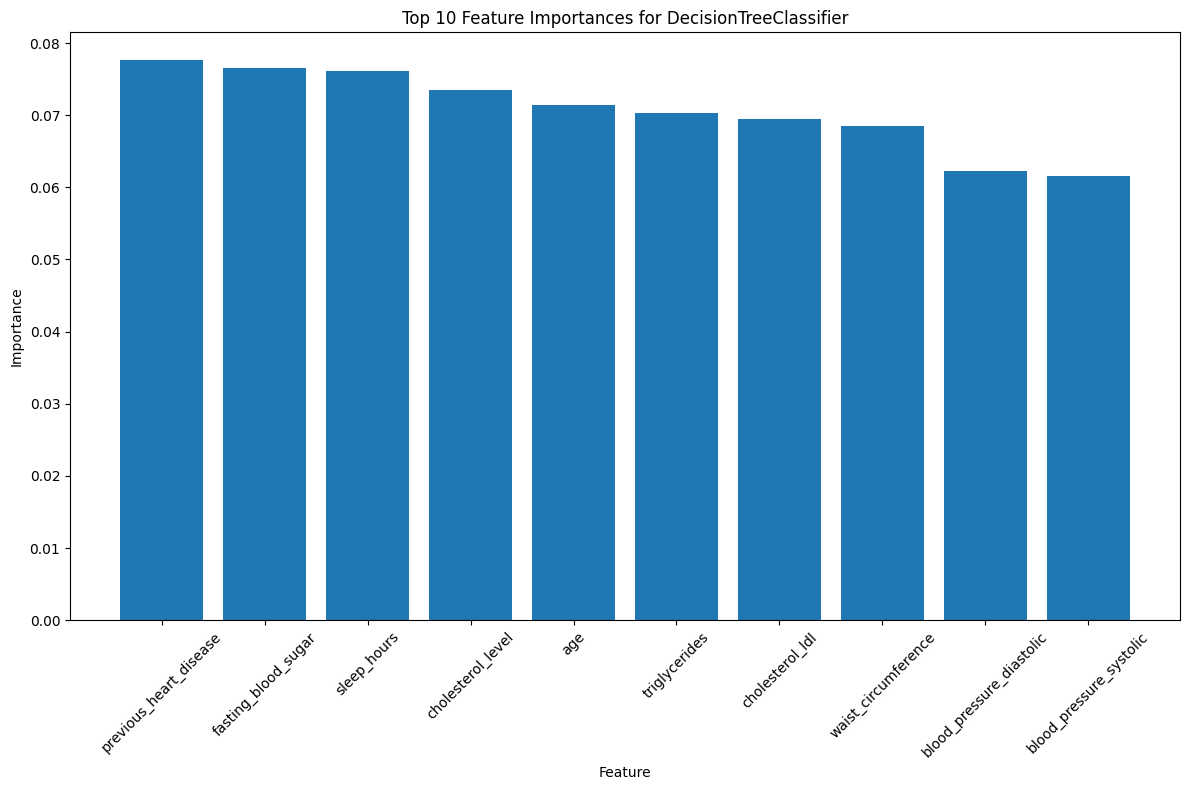

In [39]:
get_testing_results(df)

In [40]:
def get_parameter_tuning_results(df):    
    X = df.drop('heart_attack', axis=1)
    y = df['heart_attack']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models and hyperparameters
    models = [
        {'model': LogisticRegression(), 
        'params': {'C': (0.1, 10), 
                    'penalty': ['l2'],  # Change to l2 or none
                    'max_iter': (100, 1000), 
                    'tol': (0.0001, 0.1), 
                    'class_weight': ['balanced', None]}},  
        {'model': DecisionTreeClassifier(), 
        'params': {'max_depth': (3, 30), 
                    'max_features': ['sqrt', 'log2'], 
                    }}  
    ]

    # Create lists to store results
    train_results = []
    test_results = []
    feature_importances = []

    # Loop through models and calculate metrics
    for model_dict in models:
        model = model_dict['model']
        params = model_dict['params']

        # Perform hyperparameter tuning using Bayes Search
        bayes_search = BayesSearchCV(model, params, cv=5, scoring='f1_macro', n_iter=10)
        bayes_search.fit(X_train, y_train)

        # Get the best model and its hyperparameters
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_

        # Train the best model and calculate metrics
        best_model.fit(X_train, y_train)
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        if isinstance(best_model, DecisionTreeClassifier):
            fig = plt.figure(figsize=(25,20))
            _ = tree.plot_tree(best_model,
                feature_names=X.columns,
                class_names=['No Disease', "Disease"],
                filled=True)
        cm_train = confusion_matrix(y_train, y_pred_train)
        cm_test = confusion_matrix(y_test, y_pred_test)
        f1_train = f1_score(y_train, y_pred_train)
        f1_test = f1_score(y_test, y_pred_test)
        fnr_train = cm_train[1, 0] / (cm_train[1, 0] + cm_train[1, 1])
        fnr_test = cm_test[1, 0] / (cm_test[1, 0] + cm_test[1, 1])
        train_results.append({'model': type(model).__name__, 'f1_score': f1_train, 'false_negative_rate': fnr_train, 'best_params': best_params})
        test_results.append({'model': type(model).__name__, 'f1_score': f1_test, 'false_negative_rate': fnr_test, 'best_params': best_params})

        # Get feature importances
        if isinstance(model, DecisionTreeClassifier):
            importances = best_model.feature_importances_
        elif isinstance(model, LogisticRegression):
            importances = np.abs(best_model.coef_[0])
        feature_importances.append({
            'model': type(model).__name__,
            'feature_importances': importances
        })

    # Create DataFrames from the results
    train_results_df = pd.DataFrame(train_results)
    test_results_df = pd.DataFrame(test_results)

    print("Training Results:")
    print(train_results_df)
    print("\nTesting Results:")
    print(test_results_df)

    # Plot top 10 feature importances for each model
    for feature_importance in feature_importances:
        model_name = feature_importance['model']
        importances = feature_importance['feature_importances']
        top_10_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)[:10]
        plt.figure(figsize=(12, 8))  # Make the graph bigger
        plt.bar([x[0] for x in top_10_importances], [x[1] for x in top_10_importances])
        plt.title(f"Top 10 Feature Importances for {model_name}")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()



c:\Users\user\anaconda3\envs\CUHK\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Results:
                    model  f1_score  false_negative_rate  \
0      LogisticRegression  0.629068             0.347180   
1  DecisionTreeClassifier  0.623618             0.452587   

                                         best_params  
0  {'C': 3.640786167835674, 'class_weight': 'bala...  
1          {'max_depth': 12, 'max_features': 'log2'}  

Testing Results:
                    model  f1_score  false_negative_rate  \
0      LogisticRegression  0.622285             0.358553   
1  DecisionTreeClassifier  0.561800             0.509482   

                                         best_params  
0  {'C': 3.640786167835674, 'class_weight': 'bala...  
1          {'max_depth': 12, 'max_features': 'log2'}  


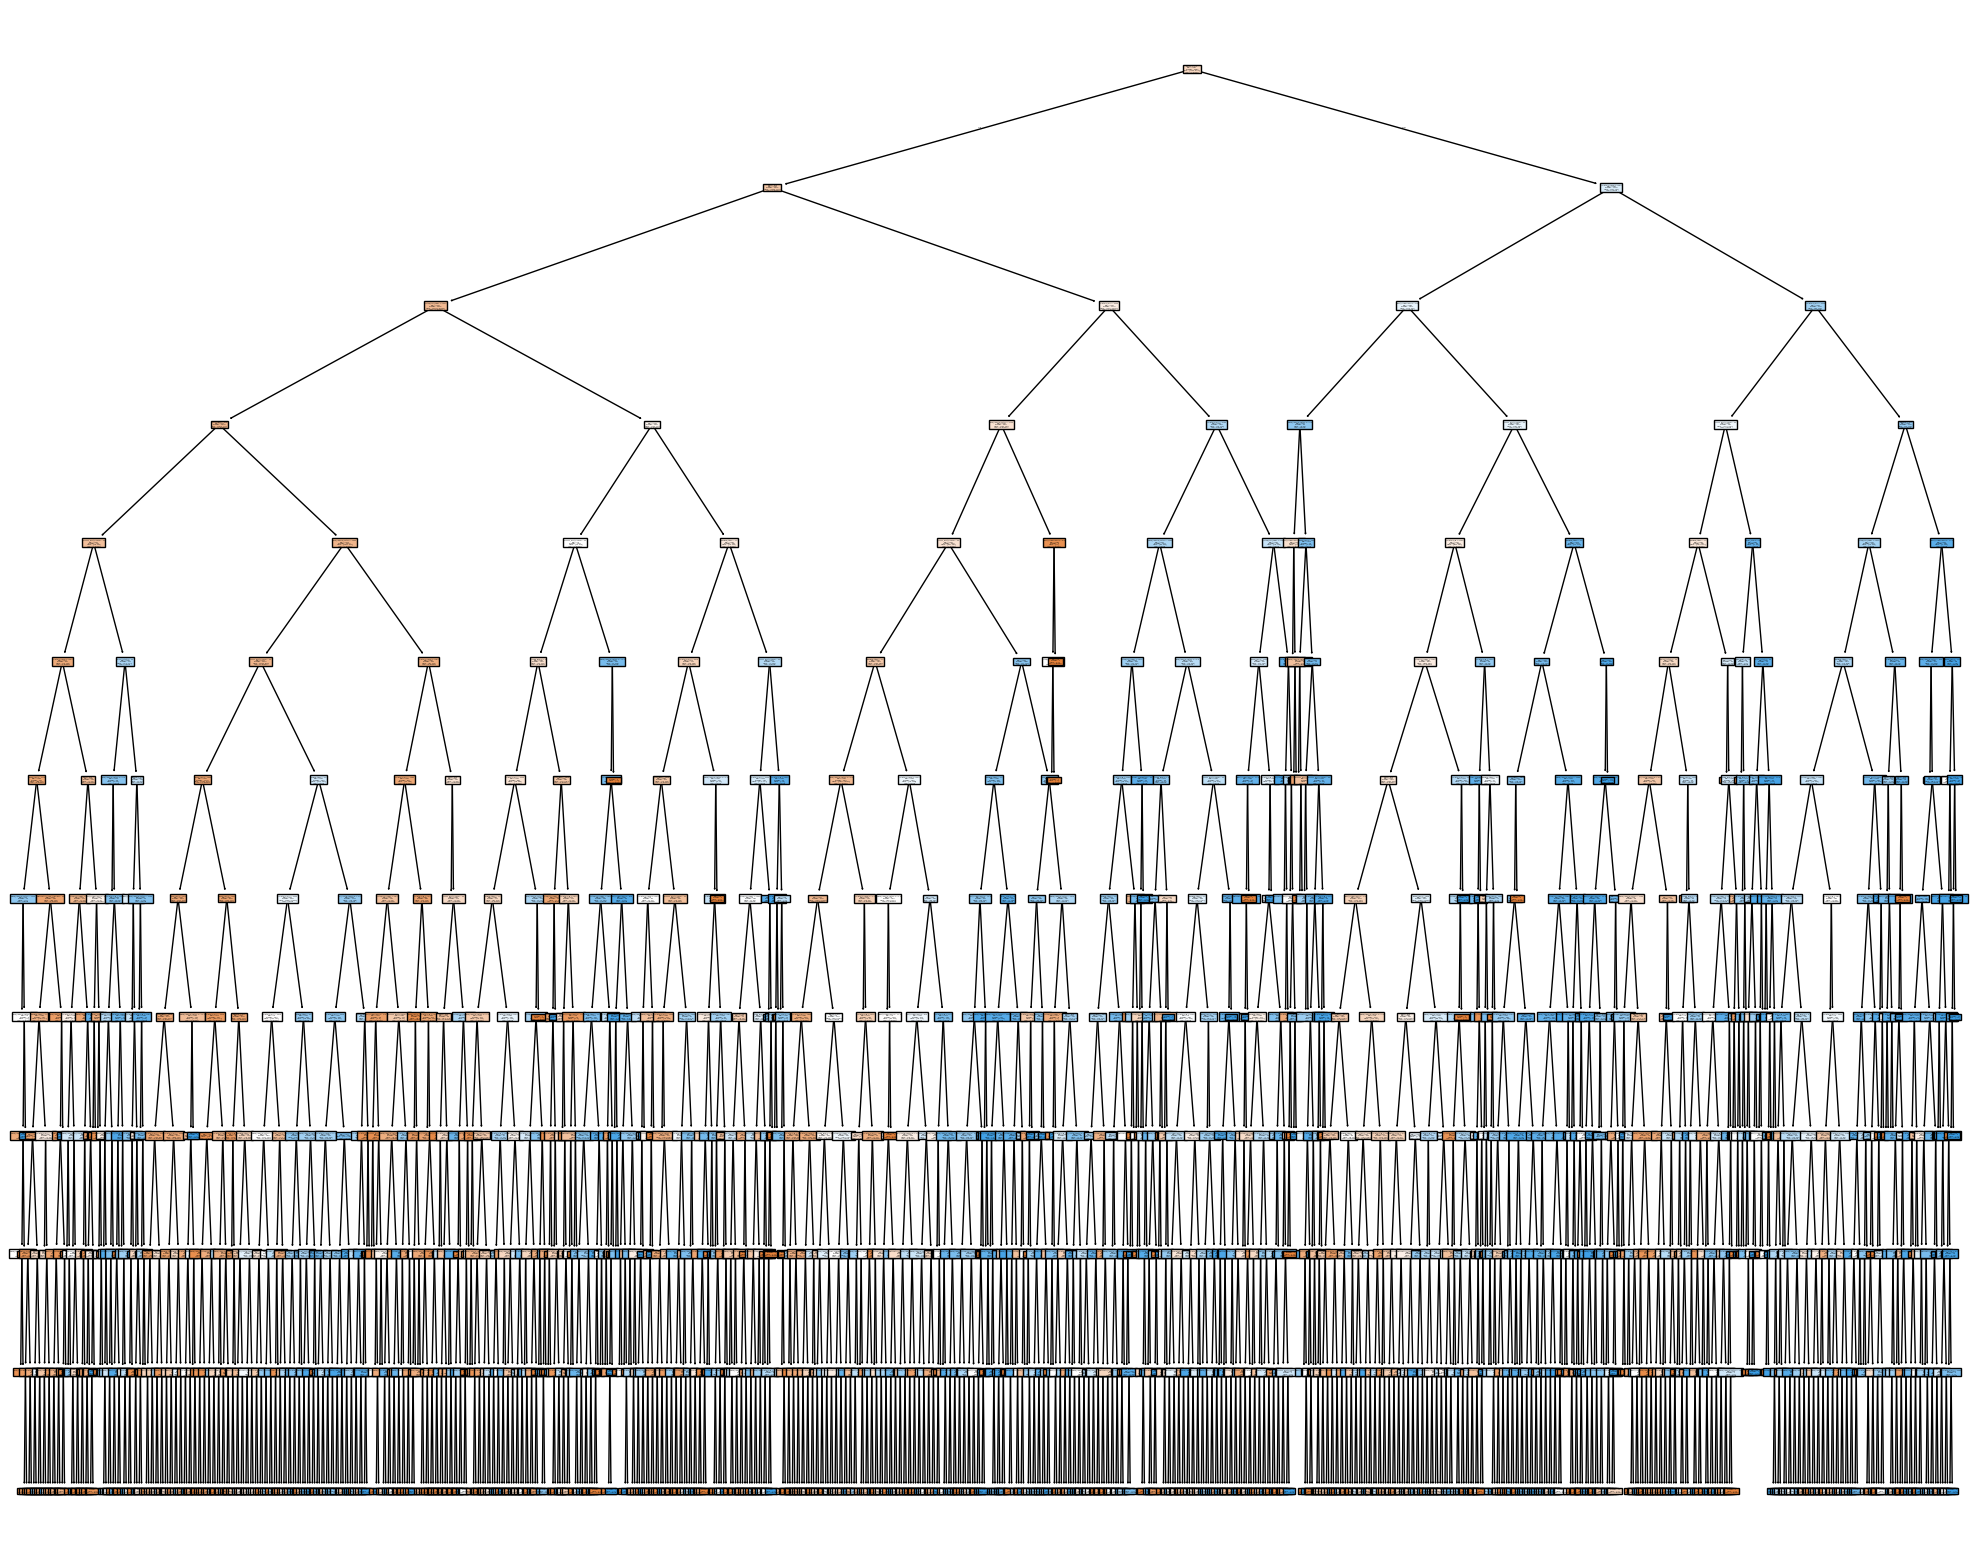

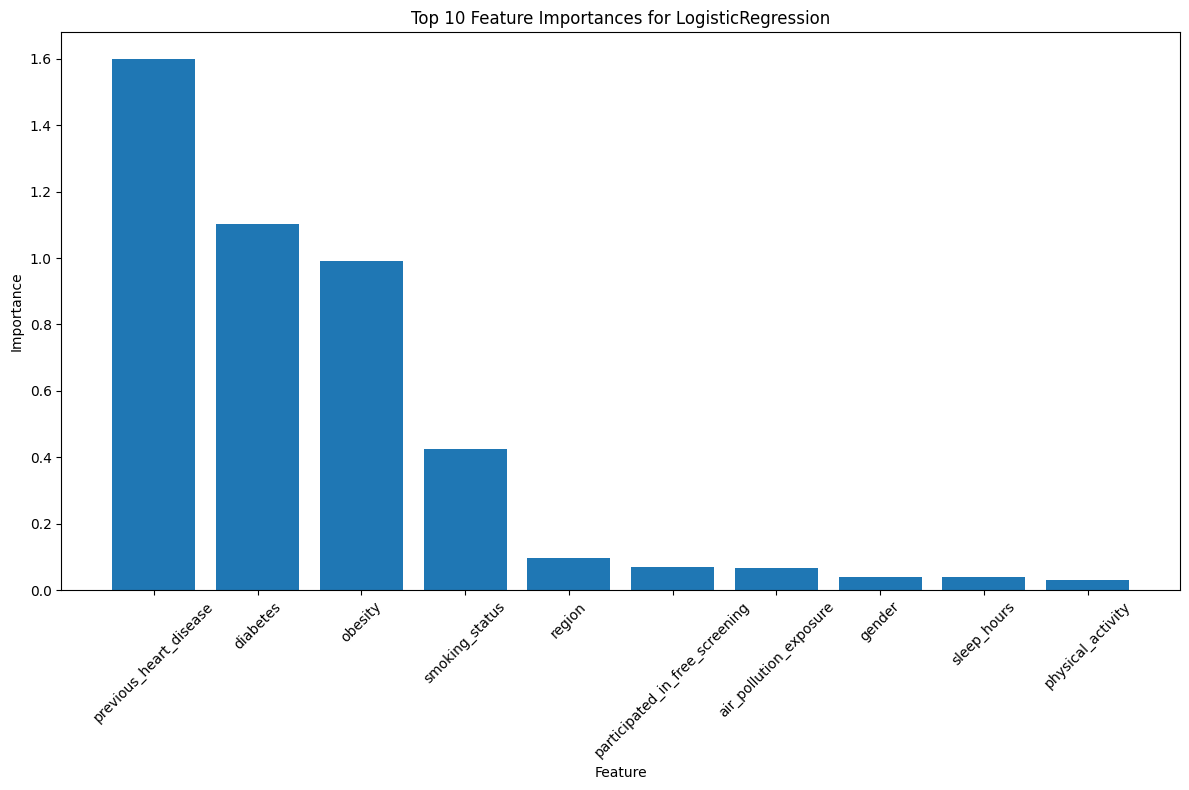

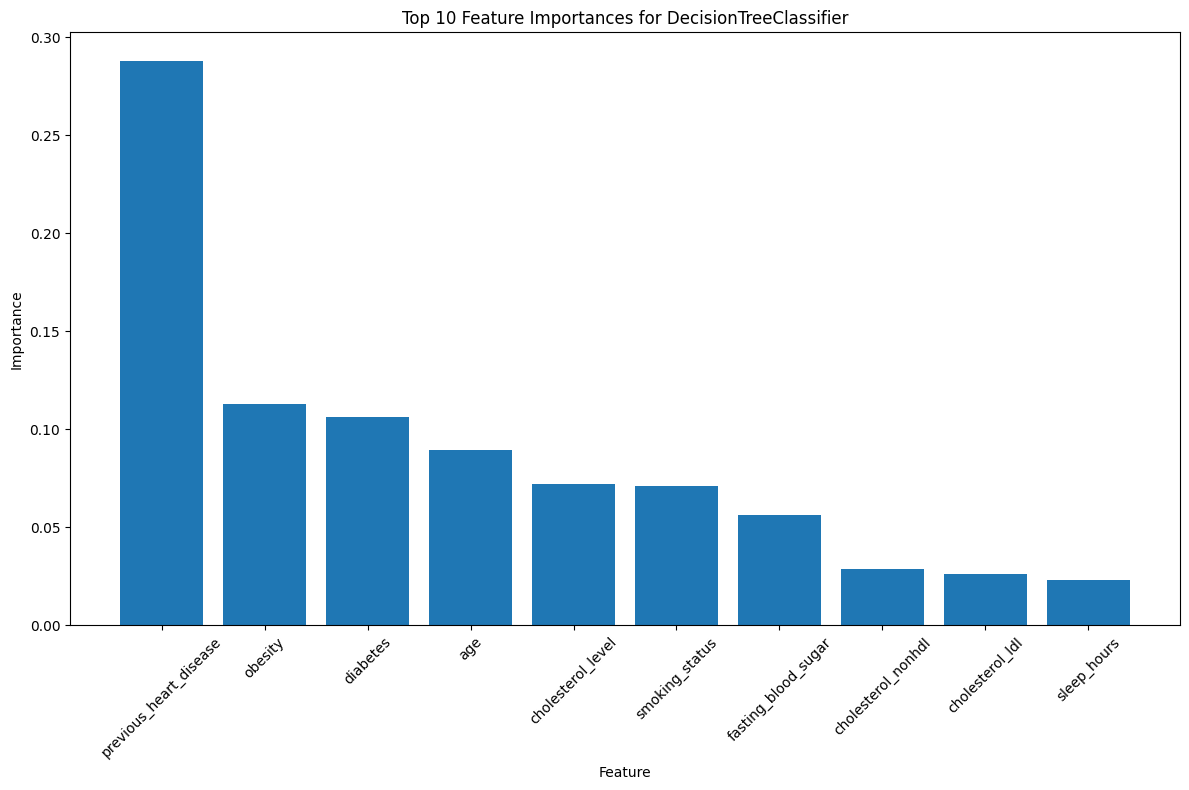

In [41]:
get_parameter_tuning_results(df)